In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from config import *
from dataset import *
from model import *
from train import *
from anomaly_score import *
from evaluate import *

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from torch.utils.data import DataLoader

# DATA

## Load Data

In [17]:
# 데이터 불러 오기

data_path = "data/ptbdb_normal.csv"
data = pd.read_csv(data_path, names=[f"sensor{i}" for i in range(188)]).iloc[:, :16]

split_size01 = int(data.shape[0] * 0.6)  # data split size
split_size02 = int(data.shape[0] * 0.9)  # data split size

# train:valid - 7:3
train = data[:split_size01]
valid = data[split_size01:split_size02]
threshold_normal = data[split_size02:]

# abnormal data
data_path = "data/ptbdb_abnormal.csv"
data = pd.read_csv(data_path, names=[f"sensor{i}" for i in range(188)]).iloc[:, :16]

split_size = int(data.shape[0] * 0.3)  # data split size

# train:valid - 7:3
threshold_abnormal = data[:split_size]
test = data[split_size:]

In [4]:
config = Config().config  # load config

## Dataset

In [18]:
train_dataset = AD_Dataset(data=train.values, config=config)
valid_dataset = AD_Dataset(data=valid.values, config=config)
threshold_normal_dataset = AD_Dataset(data=threshold_normal.values, config=config)

threshold_abnormal_dataset = AD_Dataset(data=threshold_abnormal.values, config=config)
test_dataset = AD_Dataset(data=test.values, config=config)

정규화 완료
정규화 완료
정규화 완료
정규화 완료
정규화 완료


# MODEL

In [6]:
# model
model = LSTMAutoEncoder(config=config)

# TRAIN

In [7]:
# data loader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False, num_workers=0)

# train
best_model, train_loss_arr, valid_loss_arr = trainer(
    config=config, model=model, train_loader=train_loader, valid_loader=valid_loader
)

 10%|█         | 1/10 [00:01<00:16,  1.80s/it]

save model
epoch : 1, train_loss : 0.5740692019462585, valid_loss : 0.9876536726951599


 20%|██        | 2/10 [00:03<00:14,  1.83s/it]

save model
epoch : 2, train_loss : 0.42822977900505066, valid_loss : 0.9183894395828247


 30%|███       | 3/10 [00:05<00:12,  1.79s/it]

epoch : 3, train_loss : 0.39950976769129437, valid_loss : 0.9502300024032593


 40%|████      | 4/10 [00:06<00:09,  1.59s/it]

epoch : 4, train_loss : 0.40024061997731525, valid_loss : 0.9437336325645447


 50%|█████     | 5/10 [00:07<00:07,  1.46s/it]

epoch : 5, train_loss : 0.39519686500231427, valid_loss : 0.9976145029067993


 60%|██████    | 6/10 [00:09<00:05,  1.42s/it]

epoch : 6, train_loss : 0.3921799858411153, valid_loss : 0.9876083135604858


 70%|███████   | 7/10 [00:10<00:03,  1.33s/it]

epoch : 7, train_loss : 0.3904853065808614, valid_loss : 0.9688310623168945


 80%|████████  | 8/10 [00:11<00:02,  1.30s/it]

Epoch 00008: reducing learning rate of group 0 to 2.5000e-02.
epoch : 8, train_loss : 0.38819823662439984, valid_loss : 0.9752747416496277


 90%|█████████ | 9/10 [00:12<00:01,  1.30s/it]

epoch : 9, train_loss : 0.38731799523035687, valid_loss : 0.9636232852935791


100%|██████████| 10/10 [00:14<00:00,  1.41s/it]

epoch : 10, train_loss : 0.3862740099430084, valid_loss : 0.9552053213119507


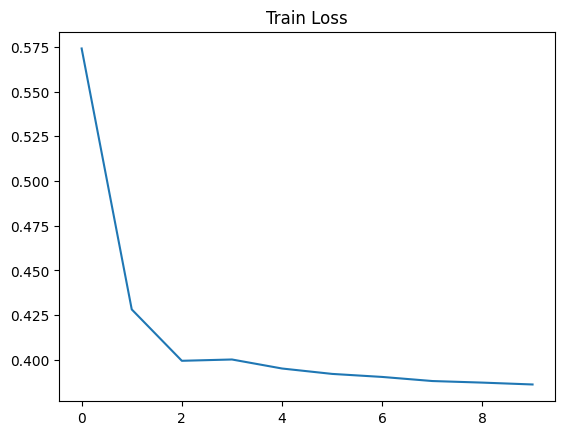

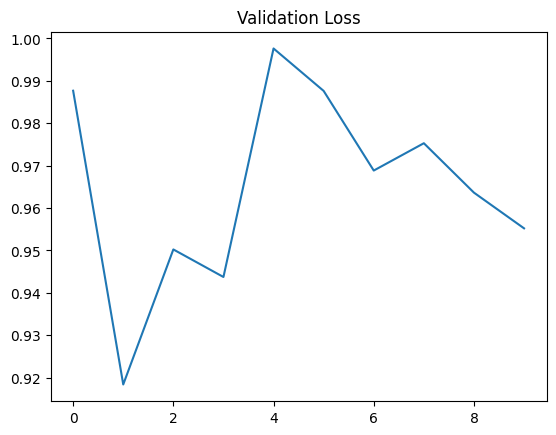

In [8]:
plt.title("Train Loss")
plt.plot(train_loss_arr)
plt.show()

plt.title("Validation Loss")
plt.plot(valid_loss_arr)
plt.show()

# ANOMALY SCORE

In [9]:
threshold_normal_loader = DataLoader(
    threshold_normal_dataset, batch_size=64, shuffle=False, num_workers=0
)

In [16]:
reconstrcution_error = get_reconstrcution_error(
    config, best_model, threshold_normal_loader
)

mean = reconstrcution_error.mean(axis=0)
sigma = np.cov(reconstrcution_error.T)

#
anomaly_calculator = Anomaly_Calculator(mean=mean, sigma=sigma)
score = anomaly_calculator(reconstrcution_error)

threshold_anomaly_scores = []

for temp_loss in tqdm(reconstrcution_error):
    threshold_anomaly_scores.append(anomaly_calculator(temp_loss))

# 정상구간에서 비정상 점수 분포
print("정상구간에서 비정상 점수 분포")
print(
    "평균[{}], 중간[{}], 최소[{}], 최대[{}]".format(
        np.mean(threshold_anomaly_scores),
        np.median(threshold_anomaly_scores),
        np.min(threshold_anomaly_scores),
        np.max(threshold_anomaly_scores),
    )
)

/Users/kimtaejong/anaconda3/envs/base311/lib/python3.11/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
1it [00:00,  7.62it/s]
100%|██████████| 256/256 [00:00<00:00, 40655.10it/s]

정상구간에서 비정상 점수 분포
평균[0.008890953335334304], 중간[0.005415701303390049], 최소[0.00015141544990292266], 최대[0.05381986607703902]


In [20]:
threshold = 0.0089

In [19]:
# abnormal data
threshold_abnormal_loader = DataLoader(
    threshold_abnormal_dataset, batch_size=64, shuffle=False, num_workers=0
)

In [ ]:
reconstrcution_error = get_reconstrcution_error(
    config, best_model, threshold_abnormal_loader
)

mean = reconstrcution_error.mean(axis=0)
sigma = np.cov(reconstrcution_error.T)

#
anomaly_calculator = Anomaly_Calculator(mean=mean, sigma=sigma)
score = anomaly_calculator(reconstrcution_error)

threshold_anomaly_scores = []

for temp_loss in tqdm(reconstrcution_error):
    threshold_anomaly_scores.append(anomaly_calculator(temp_loss))

# 정상구간에서 비정상 점수 분포
print("정상구간에서 비정상 점수 분포")
print(
    "평균[{}], 중간[{}], 최소[{}], 최대[{}]".format(
        np.mean(threshold_anomaly_scores),
        np.median(threshold_anomaly_scores),
        np.min(threshold_anomaly_scores),
        np.max(threshold_anomaly_scores),
    )
)